# Modelo Predictivo para Poverty Headcount Ratio en Honduras

Este notebook desarrolla un modelo predictivo y análisis de regresión para el **Poverty Headcount Ratio** utilizando datos socioeconómicos de Honduras.


## 1. Import Required Libraries

Importamos las librerías necesarias para el análisis de datos y machine learning.

In [2]:
# Librerías para manejo de datos
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Librerías para machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 2. Load and Explore Poverty Data

Cargamos los datasets relacionados con pobreza y otros indicadores socioeconómicos.

In [3]:
# Cargar datasets específicos para el modelo predictivo
poverty_df = pd.read_csv(f'../Datasets/Povert_headcount_ratio_at_societal_poverty_lines.csv')

# Cargar segundo dataset de pobreza (Excel)
poverty_excel_df = pd.read_excel(f'../Datasets/API_SI.POV.DDAY_DS2_en_excel_v2_607870.xls')


In [5]:
# Exploración más detallada de ambos datasets
print(" ESTADÍSTICAS DESCRIPTIVAS (CSV):")
print(poverty_df.describe())

print("\n INFORMACIÓN DETALLADA (CSV):")
print(poverty_df.info())

print("\n VALORES FALTANTES (CSV):")
print(poverty_df.isnull().sum())

if poverty_excel_df is not None:
    print("\n ESTADÍSTICAS DESCRIPTIVAS (EXCEL):")
    print(poverty_excel_df.describe())
    
    print("\n INFORMACIÓN DETALLADA (EXCEL):")
    print(poverty_excel_df.info())

 ESTADÍSTICAS DESCRIPTIVAS (CSV):
       1960  1961  1962  1963  1964  1965  1966  1967       1968       1969  \
count   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   2.000000   2.000000   
mean    NaN   NaN   NaN  18.0  18.0  18.0  18.7  18.5  12.850000  13.450000   
std     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   6.858936   6.010408   
min     NaN   NaN   NaN  18.0  18.0  18.0  18.7  18.5   8.000000   9.200000   
25%     NaN   NaN   NaN  18.0  18.0  18.0  18.7  18.5  10.425000  11.325000   
50%     NaN   NaN   NaN  18.0  18.0  18.0  18.7  18.5  12.850000  13.450000   
75%     NaN   NaN   NaN  18.0  18.0  18.0  18.7  18.5  15.275000  15.575000   
max     NaN   NaN   NaN  18.0  18.0  18.0  18.7  18.5  17.700000  17.700000   

       ...       2016       2017        2018       2019       2020       2021  \
count  ...  95.000000  90.000000  105.000000  86.000000  79.000000  88.000000   
mean   ...  23.066316  20.951111   22.332381  21.037209  20.418987  21.939773   
std    ... 

## 3. Data Preprocessing and Cleaning

Limpiamos y preparamos los datos para el análisis y modelado.

In [6]:
def clean_dataset(df, dataset_name):
    """
    Función para limpiar datasets de manera consistente
    """
    print(f"\nLimpiando dataset: {dataset_name}")
    print(f"Dimensiones originales: {df.shape}")
    
    # Copia del dataset
    df_clean = df.copy()
    
    # Filtrar solo Honduras si existe columna de país
    if 'Country Name' in df_clean.columns:
        honduras_mask = df_clean['Country Name'].str.contains('Honduras', case=False, na=False)
        df_clean = df_clean[honduras_mask]
        print(f"Datos filtrados para Honduras: {df_clean.shape}")
    
    # Identificar columnas de años (formato numérico)
    year_columns = [col for col in df_clean.columns if str(col).isdigit() and len(str(col)) == 4]
    
    if year_columns:
        # Filtrar años
        years_2010_2022 = [col for col in year_columns if 2010 <= int(col) <= 2022]
        
        # Seleccionar columnas relevantes
        keep_columns = [col for col in df_clean.columns if not str(col).isdigit() or str(col) in years_2010_2022]
        df_clean = df_clean[keep_columns]
        
        print(f"Años incluidos: {sorted([int(col) for col in years_2010_2022])}")
    
    print(f"Dimensiones finales: {df_clean.shape}")
    return df_clean

# Limpiar datasets de pobreza
poverty_clean = clean_dataset(poverty_df, "Poverty Headcount Ratio (CSV)")

if poverty_excel_df is not None:
    poverty_excel_clean = clean_dataset(poverty_excel_df, "Poverty Dataset (Excel)")
else:
    poverty_excel_clean = None
    print("Dataset de Excel no disponible para limpieza")


Limpiando dataset: Poverty Headcount Ratio (CSV)
Dimensiones originales: (266, 70)
Datos filtrados para Honduras: (1, 70)
Años incluidos: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Dimensiones finales: (1, 18)

Limpiando dataset: Poverty Dataset (Excel)
Dimensiones originales: (269, 69)
Dimensiones finales: (269, 69)


In [7]:
def reshape_to_long_format(df, dataset_name, value_column_name):
    """
    Convierte el dataset del formato wide a long format
    """
    print(f"\nConvirtiendo {dataset_name} a formato largo...")
    
    # Identificar columnas de años
    year_columns = [col for col in df.columns if str(col).isdigit() and len(str(col)) == 4]
    
    if not year_columns:
        print(f"No se encontraron columnas de años en {dataset_name}")
        return None
    
    # Columnas que no son años
    id_columns = [col for col in df.columns if col not in year_columns]
    
    # Reshape a formato largo
    df_long = pd.melt(df, 
                      id_vars=id_columns, 
                      value_vars=year_columns,
                      var_name='Year', 
                      value_name=value_column_name)
    
    # Convertir Year a int
    df_long['Year'] = df_long['Year'].astype(int)
    
    # Limpiar valores nulos
    df_long = df_long.dropna(subset=[value_column_name])
    
    print(f"Dimensiones del dataset en formato largo: {df_long.shape}")
    return df_long

# Convertir datasets a formato largo
poverty_long = reshape_to_long_format(poverty_clean, "Poverty CSV", "Poverty_Headcount_Ratio")

if poverty_excel_clean is not None:
    poverty_excel_long = reshape_to_long_format(poverty_excel_clean, "Poverty Excel", "Poverty_Excel_Indicator")
    print("\nAmbos datasets convertidos a formato largo")
else:
    poverty_excel_long = None
    print("\nSolo dataset CSV convertido a formato largo")


Convirtiendo Poverty CSV a formato largo...
Dimensiones del dataset en formato largo: (10, 7)

Convirtiendo Poverty Excel a formato largo...
No se encontraron columnas de años en Poverty Excel

Ambos datasets convertidos a formato largo


## 4. Feature Selection and Engineering

Seleccionamos y creamos variables relevantes para el modelo predictivo.

In [8]:
# Crear dataset combinado para el modelado
def create_combined_dataset():
    """
    Combina los datasets de pobreza en uno solo para el modelado
    """
    
    if poverty_long is None or poverty_long.empty:
        return None
    
    # Iniciar con el dataset principal de pobreza
    combined_df = poverty_long[['Year', 'Poverty_Headcount_Ratio']].copy()
    
    # Si hay dataset de Excel, intentar combinar
    if poverty_excel_long is not None and not poverty_excel_long.empty:
        try:
            # Intentar merge con el dataset de Excel
            excel_data = poverty_excel_long[['Year', 'Poverty_Excel_Indicator']].copy()
            combined_df = pd.merge(combined_df, excel_data, on='Year', how='left')
        except Exception as e:
            print(f"No se pudo combinar dataset de Excel: {e}")
    
    # Eliminar filas con valores nulos en la variable objetivo principal
    combined_df = combined_df.dropna(subset=['Poverty_Headcount_Ratio'])
    
    return combined_df

# Crear dataset combinado
model_data = create_combined_dataset()

if model_data is not None:
    print("\nPrimeras 5 filas:")
    display(model_data.head())


Primeras 5 filas:


,Year,Poverty_Headcount_Ratio
0,2010,34.6
1,2011,34.9
2,2012,37.3
3,2013,35.4
4,2014,35.1


Creando variables adicionales (Feature Engineering)...
Variables creadas. Nuevo tamaño: (8, 9)
Nuevas columnas: ['Year_normalized', 'Year_squared', 'Time_trend', 'Poverty_lag1', 'Poverty_Headcount_Ratio_change', 'Period', 'Poverty_Headcount_Ratio_change_change']


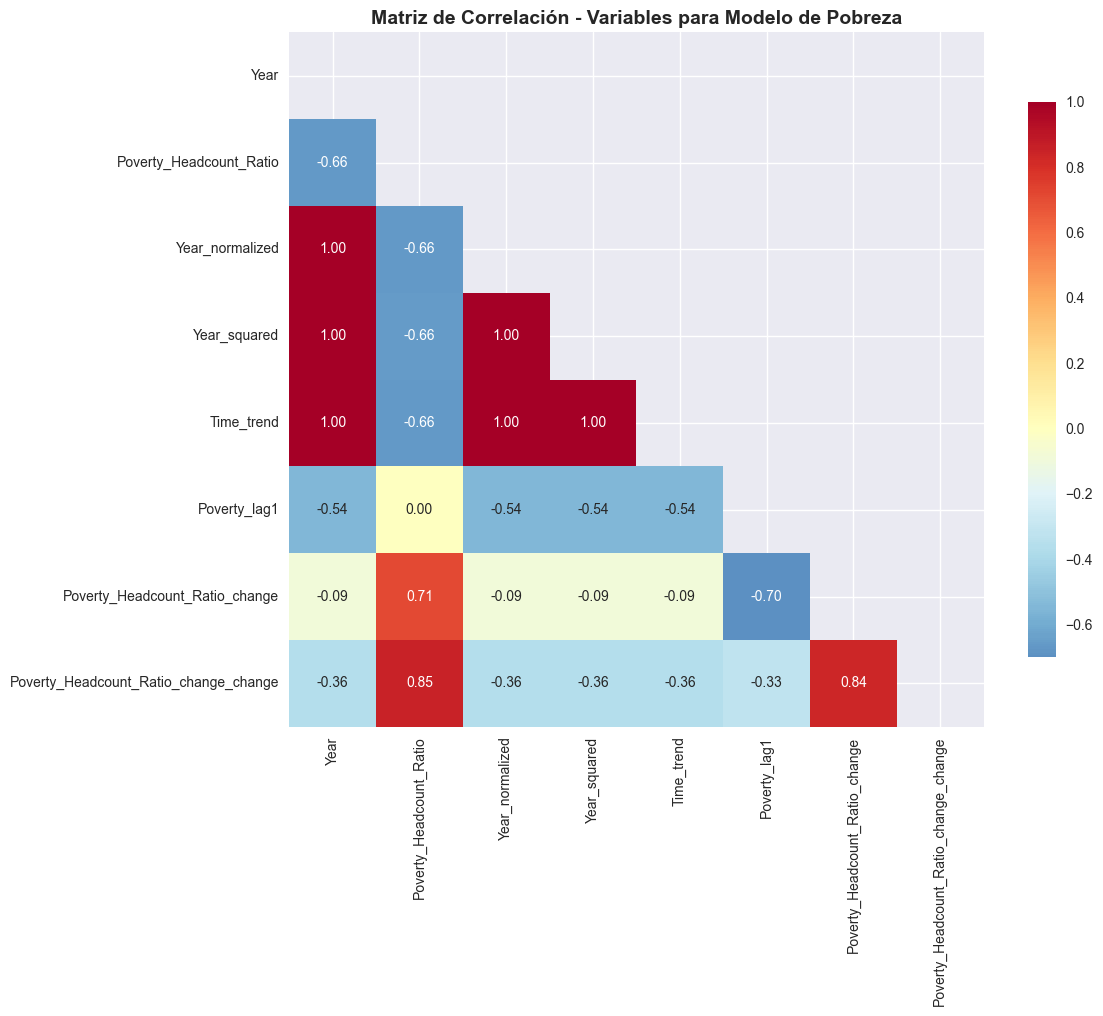

In [10]:
# Feature Engineering - Crear variables adicionales
if model_data is not None and len(model_data) > 0:
    print("Creando variables adicionales (Feature Engineering)...")
    
    # Crear variables temporales
    model_data['Year_normalized'] = (model_data['Year'] - model_data['Year'].min()) / (model_data['Year'].max() - model_data['Year'].min())
    model_data['Year_squared'] = model_data['Year'] ** 2
    model_data['Time_trend'] = range(len(model_data))
    
    # Variables de lag (valores del año anterior) si hay suficientes datos
    if len(model_data) > 1:
        model_data = model_data.sort_values('Year')
        model_data['Poverty_lag1'] = model_data['Poverty_Headcount_Ratio'].shift(1)
        
        # Si hay datos del Excel, crear variables de lag también
        if 'Poverty_Excel_Indicator' in model_data.columns:
            model_data['Poverty_Excel_lag1'] = model_data['Poverty_Excel_Indicator'].shift(1)
        
        # Crear variables de cambio porcentual
        for col in model_data.select_dtypes(include=[np.number]).columns:
            if col not in ['Year', 'Year_normalized', 'Year_squared', 'Time_trend'] and not col.endswith('_lag1'):
                change_col = f'{col}_change'
                model_data[change_col] = model_data[col].pct_change()
    
    # Variables de interacción si hay ambos datasets de pobreza
    if 'Poverty_Excel_Indicator' in model_data.columns:
        model_data['Poverty_Ratio_CSV_Excel'] = model_data['Poverty_Headcount_Ratio'] / (model_data['Poverty_Excel_Indicator'] + 0.001)
        model_data['Poverty_Diff_CSV_Excel'] = model_data['Poverty_Headcount_Ratio'] - model_data['Poverty_Excel_Indicator']
    
    # Variables categóricas basadas en períodos
    model_data['Period'] = pd.cut(model_data['Year'], 
                                  bins=[2009, 2014, 2018, 2022], 
                                  labels=['2010-2014', '2015-2018', '2019-2022'])
    
    # Eliminar filas con NaN generados por feature engineering
    model_data_clean = model_data.dropna()
    
    print(f"Variables creadas. Nuevo tamaño: {model_data_clean.shape}")
    print(f"Nuevas columnas: {[col for col in model_data_clean.columns if col not in ['Year', 'Poverty_Headcount_Ratio']]}")
    
    # Matriz de correlación
    numeric_cols = model_data_clean.select_dtypes(include=[np.number]).columns
    correlation_matrix = model_data_clean[numeric_cols].corr()
    
    # Visualizar correlaciones
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('Matriz de Correlación - Variables para Modelo de Pobreza', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
else:
    print("No hay datos suficientes para feature engineering")

## 5. Split Data for Training and Testing

Dividimos los datos en conjuntos de entrenamiento y prueba.

In [21]:
# Preparación de datos para modelado
if 'model_data_clean' in locals() and len(model_data_clean) > 0:
    print("Preparando datos para modelado...")
    
    # Seleccionar features numéricas (excluyendo variables no predictivas)
    feature_columns = [col for col in model_data_clean.select_dtypes(include=[np.number]).columns 
                       if col not in ['Poverty_Headcount_Ratio', 'Year']]
    
    # Variables predictoras (X) y variable objetivo (y)
    X = model_data_clean[feature_columns].copy()
    y = model_data_clean['Poverty_Headcount_Ratio'].copy()
    
    print(f"Variable objetivo: Poverty_Headcount_Ratio")
    print(f"Features seleccionadas ({len(feature_columns)}): {feature_columns}")
    print(f"Tamaño del dataset: {X.shape}")
    
    # Verificar si hay suficientes datos para split
    if len(X) > 3:
        # Split temporal: usar últimos años para test
        # Ordenar por año para split temporal
        data_with_year = model_data_clean.copy()
        data_with_year = data_with_year.sort_values('Year')
        
        # Usar 70% para entrenamiento, 30% para test
        split_index = int(0.7 * len(data_with_year))
        
        X_train = data_with_year[feature_columns].iloc[:split_index]
        X_test = data_with_year[feature_columns].iloc[split_index:]
        y_train = data_with_year['Poverty_Headcount_Ratio'].iloc[:split_index]
        y_test = data_with_year['Poverty_Headcount_Ratio'].iloc[split_index:]
        
        years_train = data_with_year['Year'].iloc[:split_index]
        years_test = data_with_year['Year'].iloc[split_index:]
        
        print(f"\nSplit temporal realizado:")
        print(f"Entrenamiento: {len(X_train)} observaciones (años {years_train.min()}-{years_train.max()})")
        print(f"Prueba: {len(X_test)} observaciones (años {years_test.min()}-{years_test.max()})")
        
        # También hacer split aleatorio para comparación
        X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(
            X, y, test_size=0.3, random_state=42)
        
        print(f"\nSplit aleatorio realizado:")
        print(f"Entrenamiento: {len(X_train_rand)} observaciones")
        print(f"Prueba: {len(X_test_rand)} observaciones")
        
        # Mostrar estadísticas de los splits
        print(f"\nEstadísticas de los conjuntos:")
        print(f"Train temporal - Media: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
        print(f"Test temporal - Media: {y_test.mean():.2f}, Std: {y_test.std():.2f}")
        print(f"Train aleatorio - Media: {y_train_rand.mean():.2f}, Std: {y_train_rand.std():.2f}")
        print(f"Test aleatorio - Media: {y_test_rand.mean():.2f}, Std: {y_test_rand.std():.2f}")
        
    else:
        print("No hay suficientes datos para hacer split. Se usará validación cruzada.")
        X_train, X_test, y_train, y_test = X, X, y, y
        X_train_rand, X_test_rand, y_train_rand, y_test_rand = X, X, y, y
        
else:
    print("No hay datos limpios disponibles para modelado")

Preparando datos para modelado...
Variable objetivo: Poverty_Headcount_Ratio
Features seleccionadas (5): ['Year_normalized', 'Year_squared', 'Time_trend', 'Poverty_lag1', 'Poverty_Headcount_Ratio_change']
Tamaño del dataset: (9, 5)

Split temporal realizado:
Entrenamiento: 6 observaciones (años 2011-2016)
Prueba: 3 observaciones (años 2017-2019)

Split aleatorio realizado:
Entrenamiento: 6 observaciones
Prueba: 3 observaciones

Estadísticas de los conjuntos:
Train temporal - Media: 35.65, Std: 0.86
Test temporal - Media: 34.60, Std: 0.62
Train aleatorio - Media: 35.05, Std: 0.51
Test aleatorio - Media: 35.80, Std: 1.45


## 6. Build Regression Model

Creamos y entrenamos diferentes modelos de regresión.

In [28]:
# Definir múltiples modelos de regresión
def create_regression_models():
    """
    Crear diccionario con diferentes modelos de regresión
    """
    models = {
        'Linear_Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ]),
        
        'Ridge_Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', Ridge(alpha=1.0, random_state=42))
        ]),
        
        'Lasso_Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', Lasso(alpha=0.1, random_state=42, max_iter=1000))
        ]),
        
        'Random_Forest': RandomForestRegressor(
            n_estimators=100, 
            random_state=42, 
            max_depth=3,
            min_samples_split=2
        ),
        
        'Gradient_Boosting': GradientBoostingRegressor(
            n_estimators=100,
            random_state=42,
            max_depth=3,
            learning_rate=0.1
        ),
        
        'Polynomial_Regression': Pipeline([
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])
    }
    
    return models

# Crear modelos
if 'X_train' in locals():
    print("Creando modelos de regresión...")
    models = create_regression_models()
    
    print(f"{len(models)} modelos creados:")
    for name in models.keys():
        print(f"  - {name}")
        
    # Verificar dimensiones
    print(f"\nDimensiones de entrenamiento: {X_train.shape}")
    print(f"Dimensiones de prueba: {X_test.shape}")
else:
    print("No hay datos de entrenamiento disponibles")

Creando modelos de regresión...
6 modelos creados:
  - Linear_Regression
  - Ridge_Regression
  - Lasso_Regression
  - Random_Forest
  - Gradient_Boosting
  - Polynomial_Regression

Dimensiones de entrenamiento: (6, 5)
Dimensiones de prueba: (3, 5)


## 7. Model Training and Validation

Entrenamos los modelos y realizamos validación cruzada.

In [29]:
# Entrenar y evaluar modelos
def train_and_evaluate_models(models, X_train, y_train, X_test, y_test, split_name=""):
    """
    Entrena y evalúa múltiples modelos
    """
    results = {}
    
    print(f"Entrenando modelos {split_name}...")
    
    for name, model in models.items():
        try:
            print(f"\Entrenando {name}...")
            
            # Entrenar modelo
            model.fit(X_train, y_train)
            
            # Predicciones
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            
            # Métricas de entrenamiento
            train_r2 = r2_score(y_train, y_pred_train)
            train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
            train_mae = mean_absolute_error(y_train, y_pred_train)
            
            # Métricas de prueba
            test_r2 = r2_score(y_test, y_pred_test)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
            test_mae = mean_absolute_error(y_test, y_pred_test)
            
            # Validación cruzada (solo si hay suficientes datos)
            cv_scores = []
            if len(X_train) > 3:
                try:
                    cv_scores = cross_val_score(model, X_train, y_train, cv=min(3, len(X_train)), 
                                                 scoring='r2', n_jobs=-1)
                except:
                    cv_scores = [train_r2]  # Fallback si CV falla
            else:
                cv_scores = [train_r2]
            
            # Guardar resultados
            results[name] = {
                'model': model,
                'train_r2': train_r2,
                'train_rmse': train_rmse,
                'train_mae': train_mae,
                'test_r2': test_r2,
                'test_rmse': test_rmse,
                'test_mae': test_mae,
                'cv_mean': np.mean(cv_scores),
                'cv_std': np.std(cv_scores),
                'y_pred_train': y_pred_train,
                'y_pred_test': y_pred_test
            }
            
            print(f"R² Test: {test_r2:.4f}, RMSE: {test_rmse:.4f}, CV R²: {np.mean(cv_scores):.4f}±{np.std(cv_scores):.4f}")
            
        except Exception as e:
            print(f"Error entrenando {name}: {str(e)}")
            continue
    
    return results

# Entrenar modelos con ambos splits
if 'models' in locals() and 'X_train' in locals():
    # Split temporal
    results_temporal = train_and_evaluate_models(models, X_train, y_train, X_test, y_test, "(Split Temporal)")
    
    # Split aleatorio
    results_random = train_and_evaluate_models(models, X_train_rand, y_train_rand, X_test_rand, y_test_rand, "(Split Aleatorio)")
    
    print("\nEntrenamiento completado!")
else:
    print("No se pueden entrenar los modelos - faltan datos o modelos")

Entrenando modelos (Split Temporal)...
\Entrenando Linear_Regression...
R² Test: 0.9795, RMSE: 0.0731, CV R²: 0.8709±0.1393
\Entrenando Ridge_Regression...
R² Test: 0.9795, RMSE: 0.0731, CV R²: 0.8709±0.1393
\Entrenando Ridge_Regression...
R² Test: -0.0792, RMSE: 0.5297, CV R²: -1.2653±0.3571
\Entrenando Lasso_Regression...
R² Test: -0.0792, RMSE: 0.5297, CV R²: -1.2653±0.3571
\Entrenando Lasso_Regression...
R² Test: -0.1648, RMSE: 0.5503, CV R²: -0.9460±1.3582
\Entrenando Random_Forest...
R² Test: -0.1648, RMSE: 0.5503, CV R²: -0.9460±1.3582
\Entrenando Random_Forest...
R² Test: -3.2975, RMSE: 1.0570, CV R²: -7.2096±4.9873
\Entrenando Gradient_Boosting...
R² Test: -3.2975, RMSE: 1.0570, CV R²: -7.2096±4.9873
\Entrenando Gradient_Boosting...
R² Test: -4.0518, RMSE: 1.1461, CV R²: -11.8995±12.2501
\Entrenando Polynomial_Regression...
R² Test: -6.1939, RMSE: 1.3676, CV R²: -7.2178±8.7473
Entrenando modelos (Split Aleatorio)...
\Entrenando Linear_Regression...
R² Test: 0.9994, RMSE: 0.029

## 8. Model Evaluation and Metrics

Evaluamos el desempeño de los modelos y comparamos métricas.

COMPARACIÓN DE MODELOS:


,Modelo,Split,R² Train,R² Test,RMSE Test,MAE Test,CV R² (μ±σ)
0,Linear_Regression,Temporal,0.9999,0.9795,0.0731,0.0675,0.8709±0.1393
1,Ridge_Regression,Temporal,0.8565,-0.0792,0.5297,0.5056,-1.2653±0.3571
2,Lasso_Regression,Temporal,0.8528,-0.1648,0.5503,0.5275,-0.9460±1.3582
3,Random_Forest,Temporal,0.8007,-3.2975,1.0570,0.9152,-7.2096±4.9873
4,Gradient_Boosting,Temporal,1.0000,-4.0518,1.1461,1.0146,-11.8995±12.2501
5,Polynomial_Regression,Temporal,1.0000,-6.1939,1.3676,1.3553,-7.2178±8.7473
6,Linear_Regression,Aleatorio,1.0000,0.9994,0.0293,0.0277,-0.2424±1.6397
7,Ridge_Regression,Aleatorio,0.6680,0.5793,0.7693,0.6726,-126.2017±153.1018
8,Lasso_Regression,Aleatorio,0.2083,-0.0460,1.2130,1.0527,-105.8213±128.2058
9,Random_Forest,Aleatorio,0.6928,-0.2806,1.3422,1.0958,-75.3038±100.1485



🏆 MEJORES MODELOS:
Split Temporal: Linear_Regression (R² = 0.9795)
Split Aleatorio: Linear_Regression (R² = 0.9994)


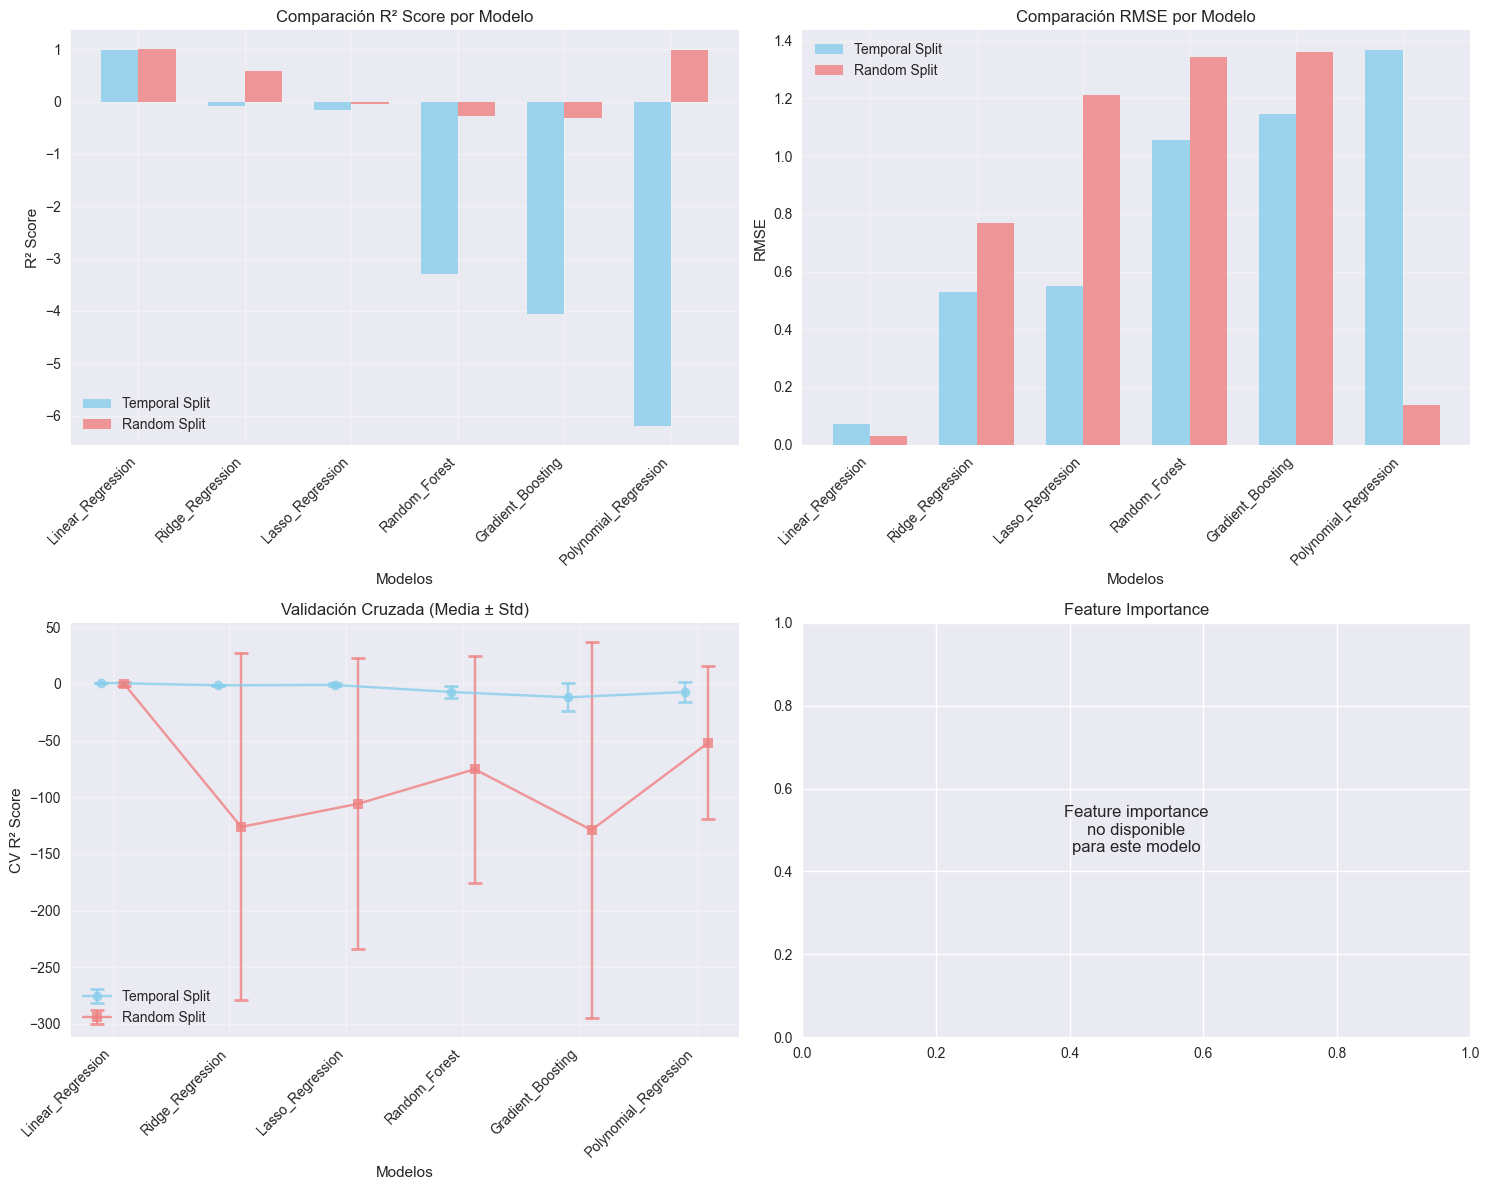

In [30]:
# Crear tabla comparativa de resultados
def create_results_comparison(results_temporal, results_random):
    """
    Crear tabla comparativa de resultados de modelos
    """
    comparison_data = []
    
    # Temporal split results
    for name, metrics in results_temporal.items():
        comparison_data.append({
            'Modelo': name,
            'Split': 'Temporal',
            'R² Train': f"{metrics['train_r2']:.4f}",
            'R² Test': f"{metrics['test_r2']:.4f}",
            'RMSE Test': f"{metrics['test_rmse']:.4f}",
            'MAE Test': f"{metrics['test_mae']:.4f}",
            'CV R² (μ±σ)': f"{metrics['cv_mean']:.4f}±{metrics['cv_std']:.4f}"
        })
    
    # Random split results
    for name, metrics in results_random.items():
        comparison_data.append({
            'Modelo': name,
            'Split': 'Aleatorio',
            'R² Train': f"{metrics['train_r2']:.4f}",
            'R² Test': f"{metrics['test_r2']:.4f}",
            'RMSE Test': f"{metrics['test_rmse']:.4f}",
            'MAE Test': f"{metrics['test_mae']:.4f}",
            'CV R² (μ±σ)': f"{metrics['cv_mean']:.4f}±{metrics['cv_std']:.4f}"
        })
    
    return pd.DataFrame(comparison_data)

# Crear y mostrar tabla comparativa
if 'results_temporal' in locals() and 'results_random' in locals():
    comparison_df = create_results_comparison(results_temporal, results_random)
    
    print("COMPARACIÓN DE MODELOS:")
    print("=" * 100)
    display(comparison_df)
    
    # Encontrar mejores modelos
    best_temporal = max(results_temporal.items(), key=lambda x: x[1]['test_r2'])
    best_random = max(results_random.items(), key=lambda x: x[1]['test_r2'])
    
    print(f"\n🏆 MEJORES MODELOS:")
    print(f"Split Temporal: {best_temporal[0]} (R² = {best_temporal[1]['test_r2']:.4f})")
    print(f"Split Aleatorio: {best_random[0]} (R² = {best_random[1]['test_r2']:.4f})")
    
    # Visualizar comparación de métricas
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # R² Score comparison
    models_names = list(results_temporal.keys())
    r2_temporal = [results_temporal[name]['test_r2'] for name in models_names]
    r2_random = [results_random[name]['test_r2'] for name in models_names]
    
    x = np.arange(len(models_names))
    width = 0.35
    
    axes[0,0].bar(x - width/2, r2_temporal, width, label='Temporal Split', alpha=0.8, color='skyblue')
    axes[0,0].bar(x + width/2, r2_random, width, label='Random Split', alpha=0.8, color='lightcoral')
    axes[0,0].set_xlabel('Modelos')
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].set_title('Comparación R² Score por Modelo')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(models_names, rotation=45, ha='right')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # RMSE comparison
    rmse_temporal = [results_temporal[name]['test_rmse'] for name in models_names]
    rmse_random = [results_random[name]['test_rmse'] for name in models_names]
    
    axes[0,1].bar(x - width/2, rmse_temporal, width, label='Temporal Split', alpha=0.8, color='skyblue')
    axes[0,1].bar(x + width/2, rmse_random, width, label='Random Split', alpha=0.8, color='lightcoral')
    axes[0,1].set_xlabel('Modelos')
    axes[0,1].set_ylabel('RMSE')
    axes[0,1].set_title('Comparación RMSE por Modelo')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(models_names, rotation=45, ha='right')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Cross-validation scores
    cv_temporal = [results_temporal[name]['cv_mean'] for name in models_names]
    cv_temporal_std = [results_temporal[name]['cv_std'] for name in models_names]
    cv_random = [results_random[name]['cv_mean'] for name in models_names]
    cv_random_std = [results_random[name]['cv_std'] for name in models_names]
    
    axes[1,0].errorbar(x - 0.1, cv_temporal, yerr=cv_temporal_std, fmt='o-', label='Temporal Split', 
                       capsize=5, capthick=2, alpha=0.8, color='skyblue')
    axes[1,0].errorbar(x + 0.1, cv_random, yerr=cv_random_std, fmt='s-', label='Random Split', 
                       capsize=5, capthick=2, alpha=0.8, color='lightcoral')
    axes[1,0].set_xlabel('Modelos')
    axes[1,0].set_ylabel('CV R² Score')
    axes[1,0].set_title('Validación Cruzada (Media ± Std)')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(models_names, rotation=45, ha='right')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Feature importance for best model (if available)
    best_model_name, best_model_results = best_temporal
    best_model = best_model_results['model']
    
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = best_model.feature_importances_
        feature_names = X_train.columns
        
        # Ordenar por importancia
        indices = np.argsort(feature_importance)[::-1]
        
        axes[1,1].bar(range(len(feature_importance)), feature_importance[indices], alpha=0.8, color='green')
        axes[1,1].set_xlabel('Features')
        axes[1,1].set_ylabel('Importancia')
        axes[1,1].set_title(f'Importancia de Features - {best_model_name}')
        axes[1,1].set_xticks(range(len(feature_importance)))
        axes[1,1].set_xticklabels([feature_names[i] for i in indices], rotation=45, ha='right')
        axes[1,1].grid(True, alpha=0.3)
    else:
        axes[1,1].text(0.5, 0.5, 'Feature importance\nno disponible\npara este modelo', 
                      ha='center', va='center', transform=axes[1,1].transAxes, fontsize=12)
        axes[1,1].set_title('Feature Importance')
    
    plt.tight_layout()
    plt.show()
else:    
    print("No hay resultados de modelos para evaluar")

## 9. Predictions and Visualization

Generamos predicciones y creamos visualizaciones comparativas.

Visualizando predicciones del mejor modelo: Linear_Regression


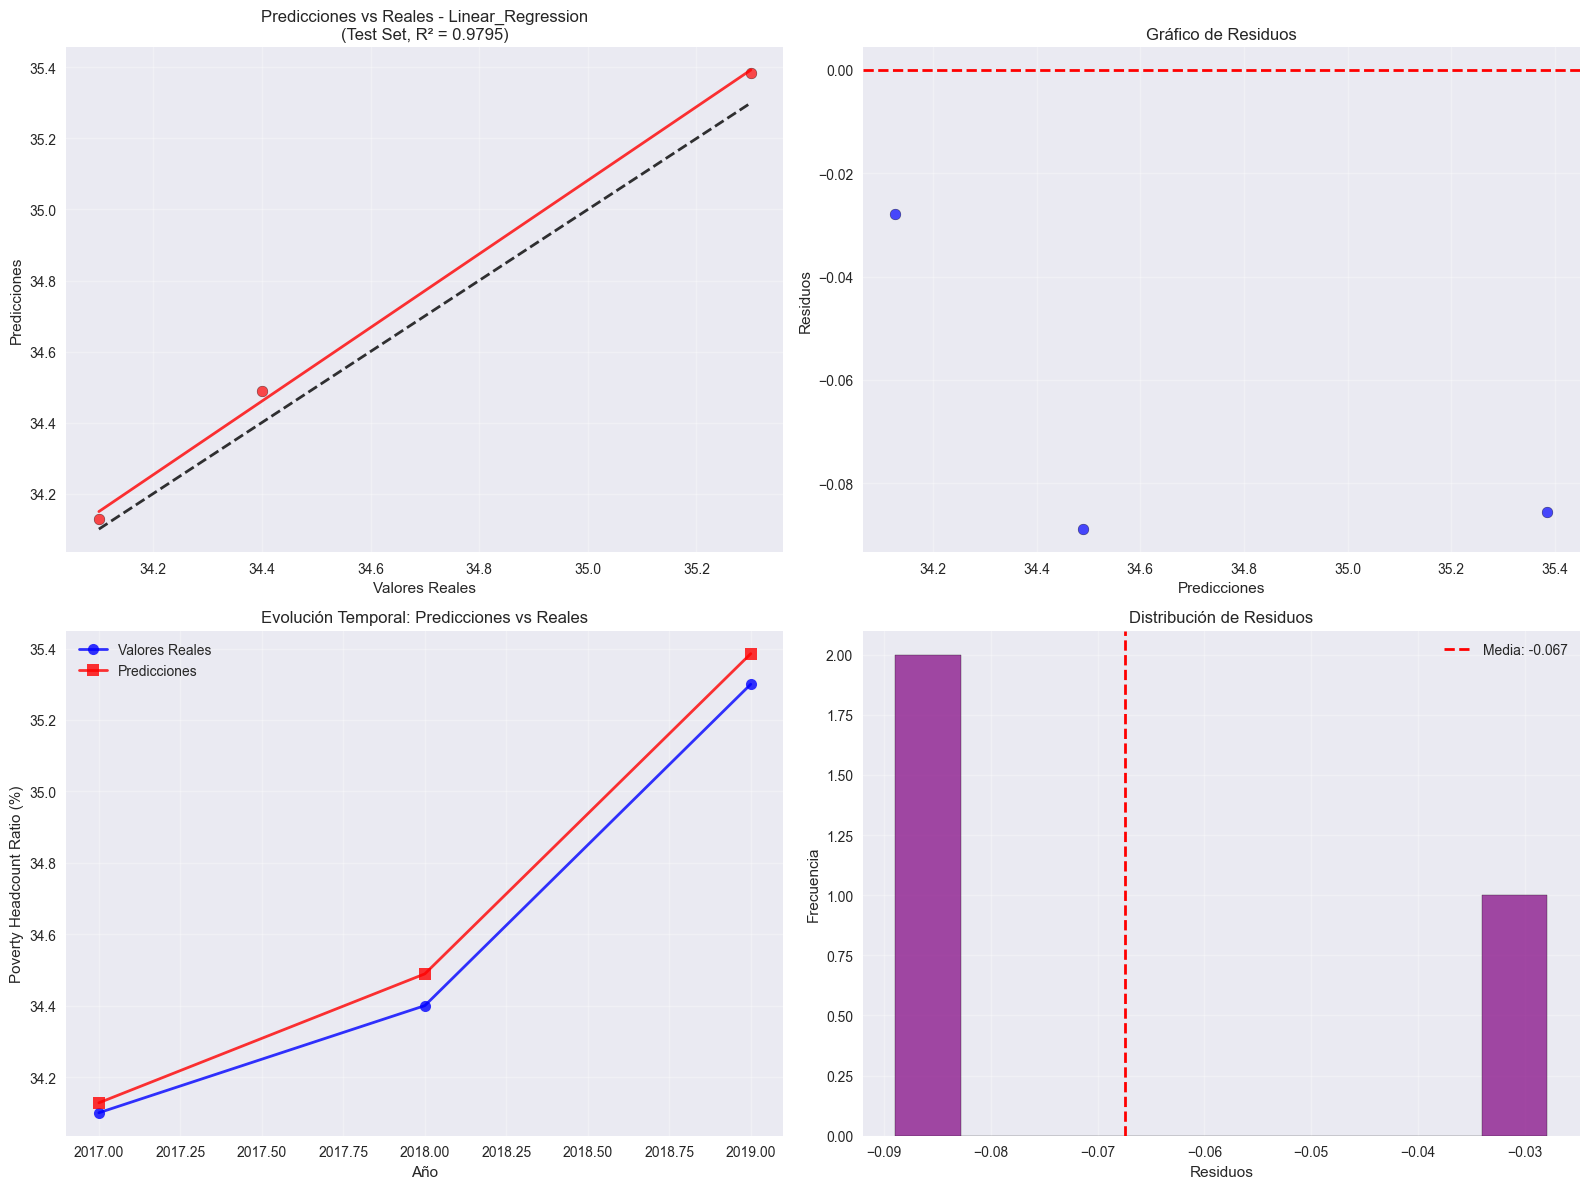

In [35]:
# Visualizaciones de predicciones vs valores reales
if 'results_temporal' in locals() and 'results_random' in locals():
    
    # Obtener mejor modelo
    best_model_name, best_model_results = max(results_temporal.items(), key=lambda x: x[1]['test_r2'])
    
    print(f"Visualizando predicciones del mejor modelo: {best_model_name}")
    
    # Crear visualizaciones
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Predicciones vs Valores Reales (Test Set)
    y_test_pred = best_model_results['y_pred_test']
    
    axes[0,0].scatter(y_test, y_test_pred, alpha=0.7, color='red', s=60, edgecolors='black')
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, alpha=0.8)
    axes[0,0].set_xlabel('Valores Reales')
    axes[0,0].set_ylabel('Predicciones')
    axes[0,0].set_title(f'Predicciones vs Reales - {best_model_name}\n(Test Set, R² = {best_model_results["test_r2"]:.4f})')
    axes[0,0].grid(True, alpha=0.3)
    
    # Añadir línea de regresión
    z = np.polyfit(y_test, y_test_pred, 1)
    p = np.poly1d(z)
    axes[0,0].plot(y_test, p(y_test), "r-", alpha=0.8, linewidth=2)
    
    # 2. Residuos
    residuals = y_test - y_test_pred
    axes[0,1].scatter(y_test_pred, residuals, alpha=0.7, color='blue', s=60, edgecolors='black')
    axes[0,1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[0,1].set_xlabel('Predicciones')
    axes[0,1].set_ylabel('Residuos')
    axes[0,1].set_title('Gráfico de Residuos')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Series temporales (si tenemos años)
    if 'years_test' in locals():
        axes[1,0].plot(years_test, y_test, 'o-', label='Valores Reales', 
                       color='blue', linewidth=2, markersize=8, alpha=0.8)
        axes[1,0].plot(years_test, y_test_pred, 's-', label='Predicciones', 
                       color='red', linewidth=2, markersize=8, alpha=0.8)
        axes[1,0].set_xlabel('Año')
        axes[1,0].set_ylabel('Poverty Headcount Ratio (%)')
        axes[1,0].set_title('Evolución Temporal: Predicciones vs Reales')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    else:
        axes[1,0].bar(['Train R²', 'Test R²', 'CV R²'], 
                      [best_model_results['train_r2'], best_model_results['test_r2'], best_model_results['cv_mean']],
                      color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.8, edgecolor='black')
        axes[1,0].set_ylabel('R² Score')
        axes[1,0].set_title('Métricas del Mejor Modelo')
        axes[1,0].grid(True, alpha=0.3)
    
    # 4. Distribución de errores
    axes[1,1].hist(residuals, bins=10, alpha=0.7, color='purple', edgecolor='black')
    axes[1,1].axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, 
                      label=f'Media: {residuals.mean():.3f}')
    axes[1,1].set_xlabel('Residuos')
    axes[1,1].set_ylabel('Frecuencia')
    axes[1,1].set_title('Distribución de Residuos')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Tabla de predicciones detalladas
    predictions_df = pd.DataFrame({
        'Año': years_test if 'years_test' in locals() else range(len(y_test)),
        'Valor_Real': y_test.values,
        'Predicción': y_test_pred,
        'Error_Absoluto': np.abs(residuals),
        'Error_Porcentual': np.abs(residuals) / y_test.values * 100
    })
    
else:
    print("No hay resultados de modelos para visualizar")

## 📈 Predicciones Futuras hasta 2030

Generamos predicciones del Poverty Headcount Ratio para Honduras hasta el año 2030 usando el mejor modelo entrenado.

In [32]:
# Generar predicciones futuras hasta 2030
def generate_future_predictions(best_model_results, model_data_clean, feature_columns, target_years=range(2023, 2031)):
    """
    Genera predicciones futuras basadas en el mejor modelo entrenado
    """
    print("Generando predicciones futuras hasta 2030...")
    
    # Obtener el mejor modelo
    best_model = best_model_results['model']
    
    # Obtener los datos históricos para calcular tendencias
    historical_data = model_data_clean.copy()
    last_year = historical_data['Year'].max()
    
    # Crear dataframe para años futuros
    future_predictions = []
    
    for year in target_years:
        # Crear features para el año futuro basado en patrones históricos
        future_features = {}
        
        # Features temporales
        year_range = historical_data['Year'].max() - historical_data['Year'].min()
        future_features['Year_normalized'] = (year - historical_data['Year'].min()) / year_range if year_range > 0 else 0
        future_features['Year_squared'] = year ** 2
        future_features['Time_trend'] = len(historical_data) + (year - last_year - 1)
        
        # Para features de lag, usar la tendencia de los últimos años
        if 'Poverty_lag1' in feature_columns:
            # Calcular tendencia promedio de los últimos 3 años disponibles
            recent_data = historical_data.tail(3)['Poverty_Headcount_Ratio']
            if len(recent_data) > 1:
                trend = recent_data.diff().mean()
                if pd.isna(trend):
                    trend = 0
                # Proyectar basado en la tendencia
                last_value = historical_data['Poverty_Headcount_Ratio'].iloc[-1]
                future_features['Poverty_lag1'] = last_value + trend * (year - last_year - 1)
            else:
                future_features['Poverty_lag1'] = historical_data['Poverty_Headcount_Ratio'].iloc[-1]
        
        # Para features de cambio porcentual, usar promedio histórico
        for col in feature_columns:
            if col.endswith('_change') and col not in future_features:
                base_col = col.replace('_change', '')
                if base_col in historical_data.columns:
                    avg_change = historical_data[col].mean()
                    if pd.isna(avg_change):
                        avg_change = 0
                    future_features[col] = avg_change
        
        # Para features de Excel (si existen), proyectar basado en correlación
        if 'Poverty_Excel_Indicator' in historical_data.columns:
            excel_corr = historical_data[['Poverty_Headcount_Ratio', 'Poverty_Excel_Indicator']].corr().iloc[0,1]
            if not pd.isna(excel_corr):
                # Proyectar Excel indicator basado en correlación
                historical_excel_trend = historical_data['Poverty_Excel_Indicator'].diff().mean()
                if pd.isna(historical_excel_trend):
                    historical_excel_trend = 0
                last_excel = historical_data['Poverty_Excel_Indicator'].iloc[-1]
                projected_excel = last_excel + historical_excel_trend * (year - last_year)
                
                if 'Poverty_Excel_lag1' in feature_columns:
                    future_features['Poverty_Excel_lag1'] = projected_excel
                if 'Poverty_Ratio_CSV_Excel' in feature_columns:
                    future_features['Poverty_Ratio_CSV_Excel'] = future_features.get('Poverty_lag1', 0) / (projected_excel + 0.001)
                if 'Poverty_Diff_CSV_Excel' in feature_columns:
                    future_features['Poverty_Diff_CSV_Excel'] = future_features.get('Poverty_lag1', 0) - projected_excel
        
        # Asegurar que todas las features necesarias estén presentes
        feature_vector = []
        for col in feature_columns:
            if col in future_features:
                feature_vector.append(future_features[col])
            else:
                # Para features faltantes, usar promedio histórico o 0
                if col in historical_data.columns:
                    avg_val = historical_data[col].mean()
                    feature_vector.append(avg_val if not pd.isna(avg_val) else 0)
                else:
                    feature_vector.append(0)
        
        # Crear DataFrame para predicción
        X_future = pd.DataFrame([feature_vector], columns=feature_columns)
        
        # Generar predicción
        try:
            prediction = best_model.predict(X_future)[0]
            
            # Asegurar que la predicción sea realista (no negativa, no extrema)
            prediction = max(0, min(prediction, 100))
            
            future_predictions.append({
                'Year': year,
                'Predicted_Poverty_Ratio': prediction
            })
            
        except Exception as e:
            print(f"Error prediciendo {year}: {e}")
            # Usar extrapolación simple como fallback
            if future_predictions:
                last_pred = future_predictions[-1]['Predicted_Poverty_Ratio']
                future_predictions.append({
                    'Year': year,
                    'Predicted_Poverty_Ratio': last_pred
                })
            else:
                future_predictions.append({
                    'Year': year,
                    'Predicted_Poverty_Ratio': historical_data['Poverty_Headcount_Ratio'].iloc[-1]
                })
    
    return pd.DataFrame(future_predictions)

# Generar predicciones si tenemos el mejor modelo
if 'best_model_results' in locals() and 'model_data_clean' in locals():
    future_df = generate_future_predictions(best_model_results, model_data_clean, feature_columns)
    
    print(f"\nPREDICCIONES FUTURAS GENERADAS:")
    print("=" * 50)
    display(future_df.round(2))
    
    # Combinar datos históricos y predicciones para visualización
    historical_summary = model_data_clean[['Year', 'Poverty_Headcount_Ratio']].copy()
    historical_summary = historical_summary.rename(columns={'Poverty_Headcount_Ratio': 'Historical_Poverty_Ratio'})
    
    # Crear dataset completo
    complete_timeline = pd.merge(
        historical_summary, 
        future_df.rename(columns={'Predicted_Poverty_Ratio': 'Future_Poverty_Ratio'}), 
        on='Year', 
        how='outer'
    ).sort_values('Year')
    
    print(f"\nRESUMEN COMPLETO (2010-2030):")
    print("=" * 50)
    display(complete_timeline.round(2))
    
else:
    print("No se pueden generar predicciones - falta el modelo entrenado o datos")

Generando predicciones futuras hasta 2030...

PREDICCIONES FUTURAS GENERADAS:


,Year,Predicted_Poverty_Ratio
0,2023,33.79
1,2024,35.07
2,2025,36.34
3,2026,37.60
4,2027,38.86
5,2028,40.12
6,2029,41.36
7,2030,42.60



RESUMEN COMPLETO (2010-2030):


,Year,Historical_Poverty_Ratio,Future_Poverty_Ratio
0,2011,34.9,NaN
1,2012,37.3,NaN
2,2013,35.4,NaN
3,2014,35.1,NaN
4,2015,35.5,NaN
5,2016,35.7,NaN
6,2017,34.1,NaN
7,2018,34.4,NaN
8,2019,35.3,NaN
9,2023,NaN,33.79


Creando visualizaciones de predicciones futuras...


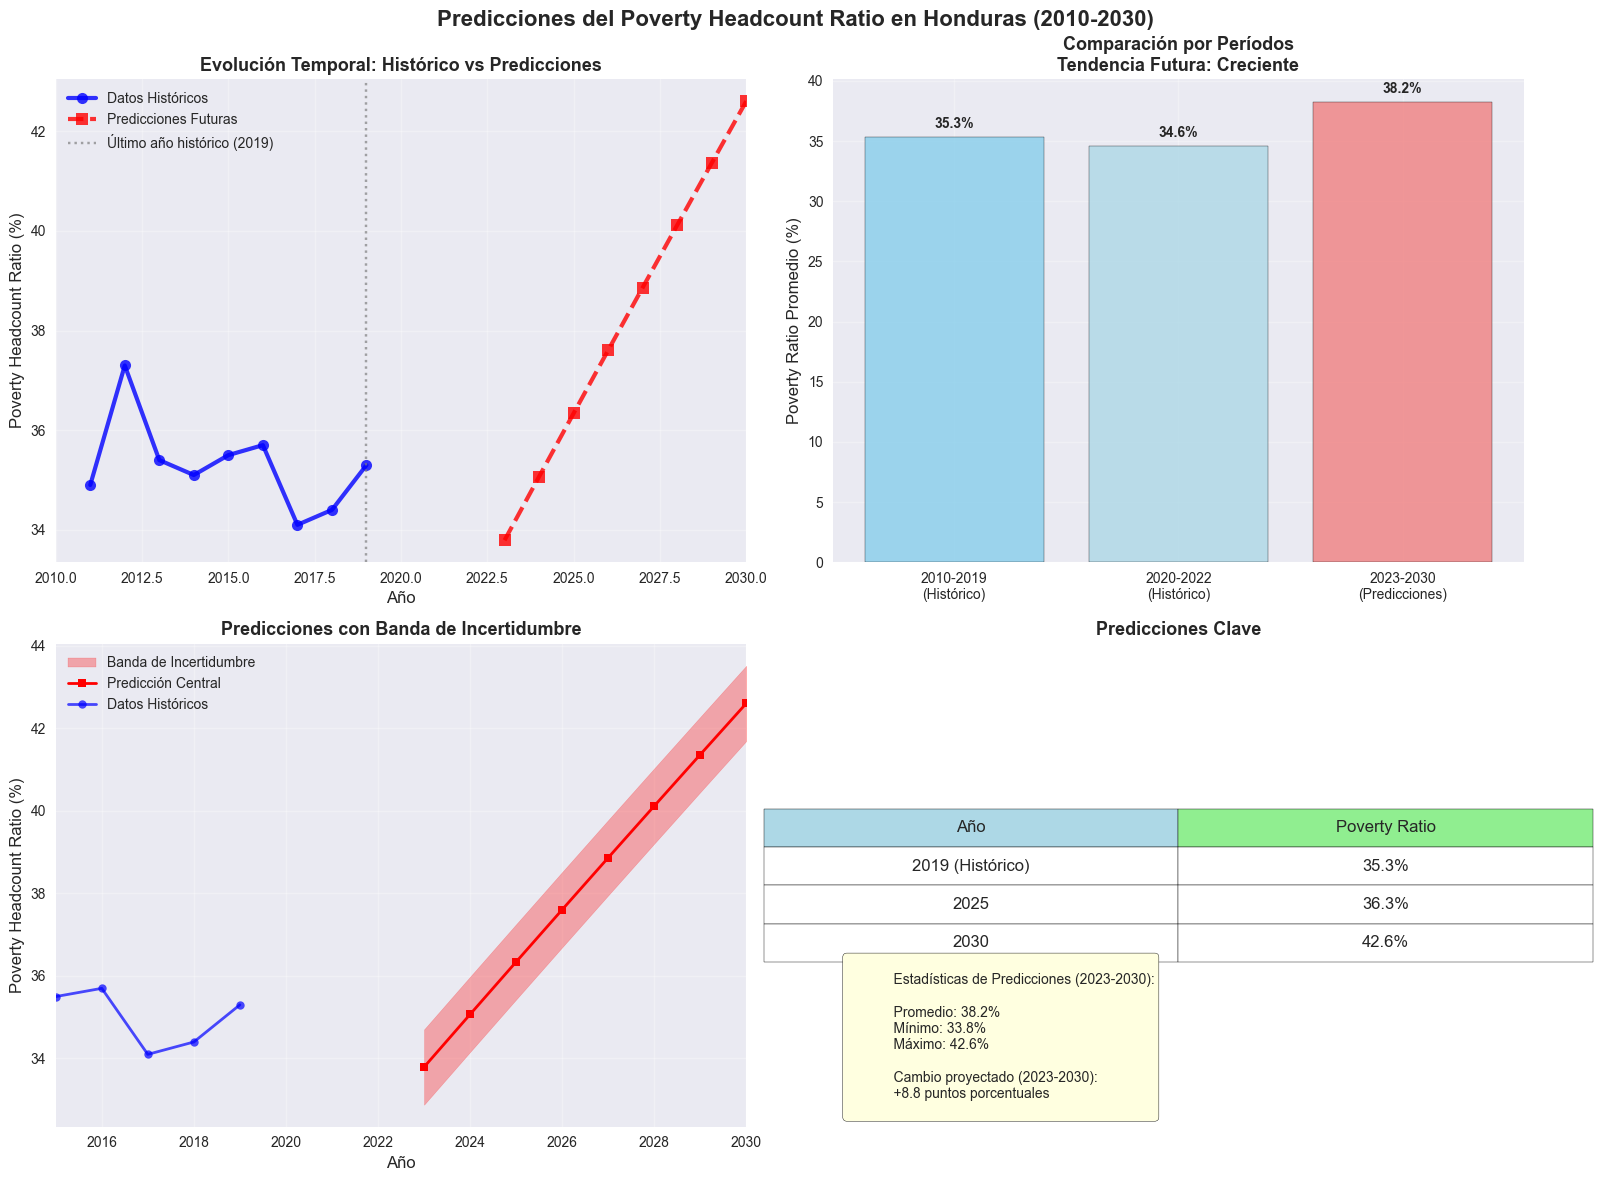

In [36]:
# Visualización de predicciones futuras
if 'future_df' in locals() and 'complete_timeline' in locals():
    
    print("Creando visualizaciones de predicciones futuras...")
    
    # Crear visualización completa
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Predicciones del Poverty Headcount Ratio en Honduras (2010-2030)', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # 1. Serie temporal completa (histórico + predicciones)
    historical_years = complete_timeline.dropna(subset=['Historical_Poverty_Ratio'])['Year']
    historical_values = complete_timeline.dropna(subset=['Historical_Poverty_Ratio'])['Historical_Poverty_Ratio']
    
    future_years = complete_timeline.dropna(subset=['Future_Poverty_Ratio'])['Year']
    future_values = complete_timeline.dropna(subset=['Future_Poverty_Ratio'])['Future_Poverty_Ratio']
    
    # Gráfico principal
    axes[0,0].plot(historical_years, historical_values, 'o-', linewidth=3, markersize=8, 
                   color='blue', label='Datos Históricos', alpha=0.8)
    axes[0,0].plot(future_years, future_values, 's--', linewidth=3, markersize=8, 
                   color='red', label='Predicciones Futuras', alpha=0.8)
    
    # Línea vertical separando histórico de predicciones
    last_historical_year = historical_years.max()
    axes[0,0].axvline(x=last_historical_year, color='gray', linestyle=':', alpha=0.7, 
                      label=f'Último año histórico ({int(last_historical_year)})')
    
    axes[0,0].set_xlabel('Año', fontsize=12)
    axes[0,0].set_ylabel('Poverty Headcount Ratio (%)', fontsize=12)
    axes[0,0].set_title('Evolución Temporal: Histórico vs Predicciones', fontsize=13, fontweight='bold')
    axes[0,0].legend(fontsize=10)
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_xlim(2010, 2030)
    
    # 2. Análisis de tendencia
    if len(future_values) > 1:
        # Calcular tendencia futura
        future_trend = np.polyfit(range(len(future_values)), future_values, 1)[0]
        trend_direction = "Creciente" if future_trend > 0 else "Decreciente" if future_trend < 0 else "Estable"
        
        axes[0,1].bar(['2010-2019\n(Histórico)', '2020-2022\n(Histórico)', '2023-2030\n(Predicciones)'],
                      [historical_values.mean(), 
                       historical_values.tail(3).mean() if len(historical_values) >= 3 else historical_values.mean(),
                       future_values.mean()],
                      color=['skyblue', 'lightblue', 'lightcoral'], alpha=0.8, edgecolor='black')
        
        axes[0,1].set_ylabel('Poverty Ratio Promedio (%)', fontsize=12)
        axes[0,1].set_title(f'Comparación por Períodos\nTendencia Futura: {trend_direction}', 
                            fontsize=13, fontweight='bold')
        axes[0,1].grid(True, alpha=0.3)
        
        # Añadir valores en las barras
        for i, v in enumerate([historical_values.mean(), 
                               historical_values.tail(3).mean() if len(historical_values) >= 3 else historical_values.mean(),
                               future_values.mean()]):
            axes[0,1].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 3. Rango de incertidumbre (estimación simple)
    if len(historical_values) > 1:
        historical_std = historical_values.std()
        
        # Crear bandas de confianza para predicciones
        upper_bound = future_values + historical_std
        lower_bound = future_values - historical_std
        
        axes[1,0].fill_between(future_years, lower_bound, upper_bound, 
                               alpha=0.3, color='red', label='Banda de Incertidumbre')
        axes[1,0].plot(future_years, future_values, 'r-', linewidth=2, 
                       label='Predicción Central', marker='s', markersize=6)
        axes[1,0].plot(historical_years, historical_values, 'b-', linewidth=2, 
                       label='Datos Históricos', marker='o', markersize=6, alpha=0.7)
        
        axes[1,0].set_xlabel('Año', fontsize=12)
        axes[1,0].set_ylabel('Poverty Headcount Ratio (%)', fontsize=12)
        axes[1,0].set_title('Predicciones con Banda de Incertidumbre', fontsize=13, fontweight='bold')
        axes[1,0].legend(fontsize=10)
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].set_xlim(2015, 2030)
    
    # 4. Tabla resumen de predicciones clave
    key_years = [2025, 2030]
    key_predictions = future_df[future_df['Year'].isin(key_years)]
    
    if not key_predictions.empty:
        # Crear tabla visual
        table_data = []
        for _, row in key_predictions.iterrows():
            table_data.append([f"{int(row['Year'])}", f"{row['Predicted_Poverty_Ratio']:.1f}%"])
        
        # Añadir datos históricos clave para comparación
        if not historical_values.empty:
            table_data.insert(0, ["2019 (Histórico)", f"{historical_values.iloc[-1]:.1f}%"])
        
        # Crear tabla
        table = axes[1,1].table(cellText=table_data,
                                colLabels=['Año', 'Poverty Ratio'],
                                cellLoc='center',
                                loc='center',
                                colColours=['lightblue', 'lightgreen'])
        
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 2)
        
        axes[1,1].axis('off')
        axes[1,1].set_title('Predicciones Clave', fontsize=13, fontweight='bold')
        
        # Añadir estadísticas adicionales
        if len(future_values) > 0:
            stats_text = f"""
            Estadísticas de Predicciones (2023-2030):
            
            Promedio: {future_values.mean():.1f}%
            Mínimo: {future_values.min():.1f}%
            Máximo: {future_values.max():.1f}%
            
            Cambio proyectado (2023-2030):
            {future_values.iloc[-1] - future_values.iloc[0]:+.1f} puntos porcentuales
            """
            
            axes[1,1].text(0.02, 0.02, stats_text, transform=axes[1,1].transAxes,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"),
                           fontsize=10, verticalalignment='bottom')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ No se pueden crear visualizaciones - faltan datos de predicciones")